#### Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile

####Load the dataset

About the dataset: The set contains 500 rendered images of various species of horse in multiple poses in multiple locations and 527 rendered images of humans in different poses and backgrounds. There are both men and women and Asian, Black, South Asian, and Caucasians present in the training set. The validation set adds six different figures to ensure breadth of data.

All Images are 300×300 pixels in 24-bit color and arranged into sub folders within the zip.

In [2]:
local_zip = '/content/drive/MyDrive/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/drive/MyDrive/horse-or-human')
zip_ref.close()
local_zip = '/content/drive/MyDrive/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/drive/MyDrive/validation-horse-or-human')
zip_ref.close()

In [3]:
# directory with train horse pics
train_horse_dir = os.path.join('/content/drive/MyDrive/horse-or-human/horses')

# human pics
train_human_dir = os.path.join('/content/drive/MyDrive/horse-or-human/humans')


In [4]:
#file names in directories
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse13-7.png', 'horse13-8.png', 'horse13-9.png', 'horse14-0.png', 'horse14-1.png', 'horse14-2.png', 'horse14-3.png', 'horse14-4.png', 'horse14-5.png', 'horse14-7.png']
['human05-26.png', 'human05-27.png', 'human05-28.png', 'human05-29.png', 'human05-30.png', 'human06-02.png', 'human06-00.png', 'human06-01.png', 'human06-04.png', 'human06-03.png']


In [5]:
#total no of images in each directory
print('horse imgs' , len(os.listdir(train_horse_dir)))
print('human imgs' , len(os.listdir(train_human_dir)))

horse imgs 500
human imgs 527


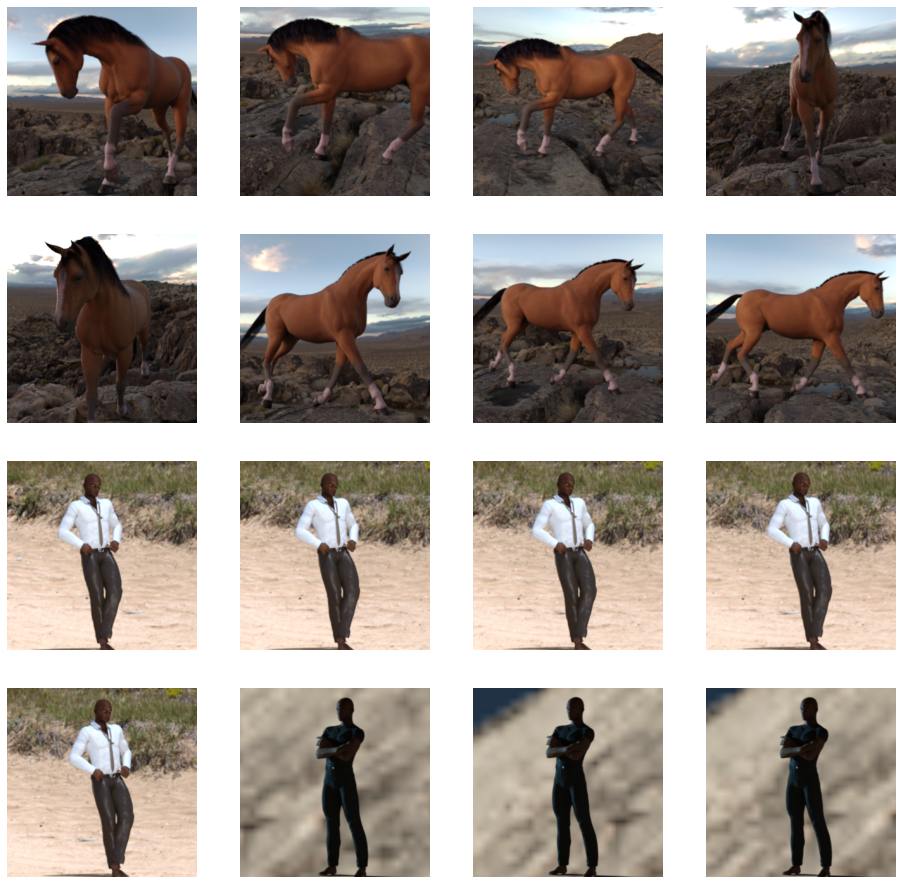

In [6]:
# configure matplot param
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# param for graph 4x4 output img config
nrows = 4
ncols = 4

# index for iterating over images
pic_index = 0

# display batch of imgs
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in train_horse_names[pic_index-8:pic_index]]

next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix + next_human_pix):
  # set up subplot;subplot index start at 1
  sp = plt.subplot(nrows,ncols, i +1 )
  sp.axis('Off')

  img= mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

####PreProcess Images 

In [7]:
# data preprocessing

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/horse-or-human',
    target_size=(300,300), batch_size=20,class_mode = 'binary')


validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    '//content/drive/MyDrive/validation-horse-or-human',
    target_size=(300,300), batch_size=20,class_mode = 'binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


####Load InceptionV3 model from TensorFlow
I used layer 'mixed10' as it gave the best results for test images

In [12]:
from tensorflow.keras import layers
from tensorflow.keras import Model
tf.keras.backend.clear_session()

from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = '/content/drive/MyDrive/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (300,300,3),
                                include_top = False,
                                weights = None)
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False #lock or freeze a layer from retraining

#pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed10')
print('last_layer_output_shape :' , last_layer.output_shape)
last_output = last_layer.output

last_layer_output_shape : (None, 8, 8, 2048)


####Add last layer and build the model

In [13]:
# build model
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics =['accuracy'])

history = model.fit(train_generator,validation_data = validation_generator, 
                    steps_per_epoch = 1027//20, epochs=10,
                    validation_steps = 256//20,verbose=2)

Epoch 1/10
51/51 - 31s - loss: 10.0992 - accuracy: 0.8947 - val_loss: 0.0155 - val_accuracy: 0.9958
Epoch 2/10
51/51 - 25s - loss: 0.1413 - accuracy: 0.9950 - val_loss: 0.0313 - val_accuracy: 0.9958
Epoch 3/10
51/51 - 25s - loss: 0.1378 - accuracy: 0.9930 - val_loss: 3.5836e-07 - val_accuracy: 1.0000
Epoch 4/10
51/51 - 26s - loss: 0.0155 - accuracy: 0.9980 - val_loss: 2.8579e-11 - val_accuracy: 1.0000
Epoch 5/10
51/51 - 25s - loss: 0.0293 - accuracy: 0.9980 - val_loss: 0.0083 - val_accuracy: 0.9958
Epoch 6/10
51/51 - 26s - loss: 0.0051 - accuracy: 0.9990 - val_loss: 1.0776e-10 - val_accuracy: 1.0000
Epoch 7/10
51/51 - 26s - loss: 0.0413 - accuracy: 0.9980 - val_loss: 2.2217e-11 - val_accuracy: 1.0000
Epoch 8/10
51/51 - 25s - loss: 6.3668e-05 - accuracy: 1.0000 - val_loss: 1.8759e-12 - val_accuracy: 1.0000
Epoch 9/10
51/51 - 24s - loss: 0.0010 - accuracy: 0.9990 - val_loss: 4.8883e-09 - val_accuracy: 1.0000
Epoch 10/10
51/51 - 26s - loss: 3.1586e-11 - accuracy: 1.0000 - val_loss: 0.0889

####Display model accuracy and loss

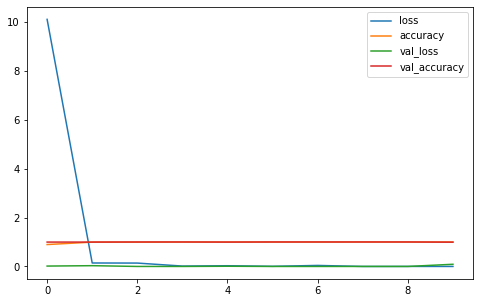

In [14]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

####Test new images

Saving h1.jpg to h1 (2).jpg
Saving h2.jpg to h2 (2).jpg
Saving h3.jpg to h3 (2).jpg
Saving h4.jpg to h4 (2).jpg
Saving h5.jpg to h5 (2).jpg
Saving hr1.jpg to hr1 (2).jpg
Saving hr2.jpg to hr2 (2).jpg
Saving hr3.jpg to hr3 (2).jpg
Saving hr4.jpg to hr4 (2).jpg
Saving hr5.jpg to hr5 (2).jpg
[1.]
h1.jpg is a human


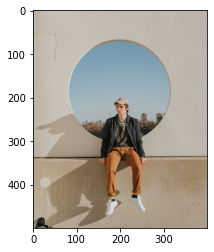

[1.]
h2.jpg is a human


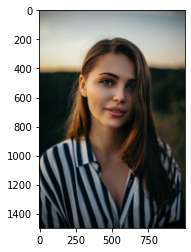

[1.]
h3.jpg is a human


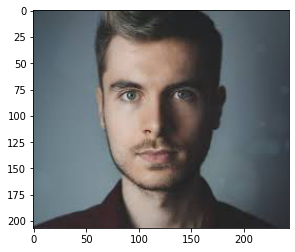

[1.]
h4.jpg is a human


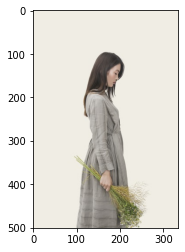

[1.]
h5.jpg is a human


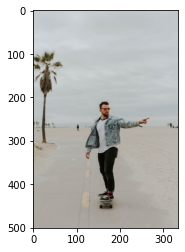

[1.359297e-32]
hr1.jpg is a horse


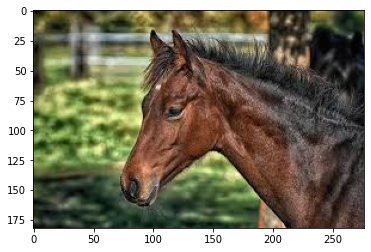

[0.]
hr2.jpg is a horse


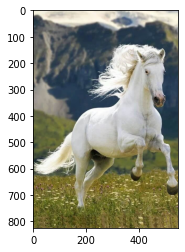

[0.]
hr3.jpg is a horse


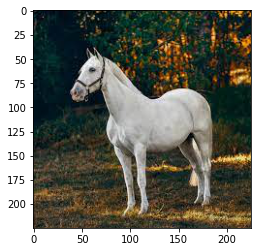

[0.]
hr4.jpg is a horse


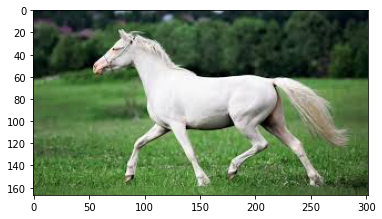

[0.]
hr5.jpg is a horse


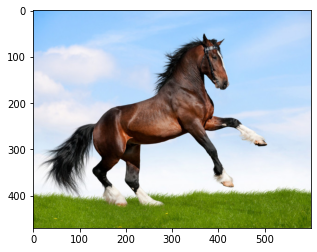

In [15]:
# running the model , choose 1 or more files , which ur model will predict
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  #predict images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300,300))
  x = image.img_to_array(img)
  x = np.expand_dims(x,axis=0)

  images  = np.vstack([x])
  classes = model.predict(images,batch_size=10)
  print(classes[0])

  pic = mpimg.imread(path)
  plt.imshow(pic)
  if classes[0]>0.5:
    print(fn + ' is a human')
    plt.show()
  else:
    print(fn + ' is a horse')
    plt.show()

Credits - Laurence Moroney